In [1]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.2/404.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.3/225.3 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.4 MB/s eta 0:00:00


In [2]:
import optuna

In [3]:
import pandas as pd
import numpy as np
import math


import sklearn
import keras
import keras.backend as K
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM, CuDNNLSTM, MaxPooling1D, Conv1D, Flatten, BatchNormalization, Dropout, Input
from tensorflow.keras.layers import Bidirectional
from keras.models import Model
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping


from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from math import sqrt

from joblib import Parallel
from joblib import delayed
from datetime import datetime

#import optuna

from sklearn.preprocessing import StandardScaler

from keras.utils import custom_object_scope
from keras.utils import get_custom_objects
from keras.models import load_model

from keras.layers import LSTM, RepeatVector, TimeDistributed, BatchNormalization, Dropout
from keras.initializers import GlorotUniform
from keras.activations import relu
from joblib import Parallel, delayed

import cProfile

import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, LSTM, Multiply, Add
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow_probability as tfp
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.optimizers import SGD
import warnings
warnings.filterwarnings('ignore')

In [4]:

dataset = pd.read_csv('/content/drive/Shareddrives/1st Paper/2nd.csv', header = 0, infer_datetime_format=True, index_col=['Date Time'])
df = dataset[[
        'S2_Top_VWC_Avg', 'S2_Top_Temp_Avg'

       ]]


In [5]:
def split_dataset(data):
  """
    Splits the dataset into train and test sets.

    Args:
        data (array): The dataset to be split.

    Returns:
        train (array): The training dataset.
        test (array): The testing dataset.
  """
  # split into standard weeks
  train, test = data[1:-6046], data[-6048:]
  #train, test = data[:-5817], data[-5817:-57] 6048
  # restructure into windows of weekly data
  train = np.array(np.split(train, len(train)/144))
  test = np.array(np.split( test , len(test )/144))
  return train, test

def to_supervised(train, n_input, n_out=144):
  #flattern data
  data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
  X, y = list(), list()
  in_start = 0
  # step over the entire history one time step at a time
  for i in range(len(data)):
    #define the end of the input sequence
    in_end = in_start + n_input
    out_end = in_end + n_out
    #ensure there is enough data
    if out_end <= len(data):
      X.append(data[in_start:in_end, :])
      y.append(data[in_end:out_end, 0])
    # move along one time step
    in_start += 1
  return np.array(X), np.array(y)

def build_moe_model_with_autoencoder_cnn_attention(input_dim, output_dim, expert_hidden_sizes, expert_output_sizes,
                                     gating_hidden_sizes, num_experts, learning_rate, activation, kernel_initializer, dropout_rate,
                                     num_iterations=100):
    """
    Builds a Mixture of Experts (MoE) model with autoencoder, CNN and attention mechanisms.

    Args:
        input_dim (int): The dimension of input features.
        output_dim (int): The dimension of output features.
        expert_hidden_sizes (list): The hidden layer sizes for each expert.
        expert_output_sizes (list): The output layer sizes for each expert.
        gating_hidden_sizes (list): The hidden layer sizes for the gating network.
        num_experts (int): The number of experts in the model.
        learning_rate (float): The learning rate for the optimizer.
        activation (str): The activation function to be used in the hidden layers.
        kernel_initializer (str): The kernel initializer for the layers.
        dropout_rate (float): The dropout rate for dropout layers.
        num_iterations (int, optional): The number of iterations for training. Defaults to 100.

    Returns:
        moe_model (Model): The Mixture of Experts model.
        experts (list): The list of expert models.
        gating_model (Model): The gating network model.
    """
    experts = []
    for i in range(num_experts):
        if i == 0:  # Replace first expert with an autoencoder
            expert_input = Input(shape=(input_dim))
            expert_hidden = Dense(expert_hidden_sizes[i], activation=activation, kernel_initializer=kernel_initializer)(expert_input)
            expert_hidden = Dropout(dropout_rate)(expert_hidden)
            expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for LSTM input
            expert_hidden, _, _ = LSTM(expert_hidden_sizes[i], return_state=True, kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(expert_hidden_sizes[i], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
            expert_hidden = Multiply()([expert_hidden, attention])
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_hidden)
            experts.append(Model(inputs=expert_input, outputs=expert_output))
        elif i == 1:  # Replace second expert with a Transformer expert
            expert_input = Input(shape=(input_dim))
            expert_hidden = Dense(expert_hidden_sizes[i], activation=activation, kernel_initializer=kernel_initializer)(expert_input)
            expert_hidden = Dropout(dropout_rate)(expert_hidden)
            expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for Transformer input
            expert_hidden = MultiHeadAttention(num_heads=8, key_dim=expert_hidden_sizes[i])(expert_hidden, expert_hidden)
            expert_hidden = Flatten()(expert_hidden)
            attention = Dense(expert_hidden_sizes[i], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
            expert_hidden = Multiply()([expert_hidden, attention])
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_hidden)
            experts.append(Model(inputs=expert_input, outputs=expert_output))
        else:  # Replace third expert with a GRU-based model
            expert_input = Input(shape=(input_dim))
            expert_hidden = Dense(expert_hidden_sizes[i], activation=activation, kernel_initializer=kernel_initializer)(expert_input)
            expert_hidden = Dropout(dropout_rate)(expert_hidden)
            expert_hidden = tf.expand_dims(expert_hidden, axis=1)  # Expand dimensions for GRU input
            expert_hidden, _ = GRU(expert_hidden_sizes[i], return_state=True, kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(expert_hidden_sizes[i], activation='tanh', kernel_initializer='he_normal')(expert_hidden)
            attention = Dense(1, activation='softmax', kernel_initializer='he_normal')(attention)
            expert_hidden = Multiply()([expert_hidden, attention])
            expert_output = Dense(output_dim, activation='linear', kernel_initializer='he_normal')(expert_hidden)
            experts.append(Model(inputs=expert_input, outputs=expert_output))

    # Define the gating network
    gating_input = Input(shape=(input_dim,))
    gating_hidden = Dense(gating_hidden_sizes[0], activation='relu', kernel_initializer='he_normal')(gating_input)
    gating_hidden = Dropout(dropout_rate)(gating_hidden)
    gating_hidden = tf.expand_dims(gating_hidden, axis=1)  # Expand dimensions for LSTM input
    gating_hidden = MultiHeadAttention(num_heads=8, key_dim=gating_hidden_sizes[1])(gating_hidden, gating_hidden)
    gating_hidden = Flatten()(gating_hidden)

    gating_output = Dense(num_experts + num_experts * 2, activation=None, kernel_initializer='he_normal')(gating_hidden)

    logits = gating_output[:, :num_experts]
    params = gating_output[:, num_experts:]
    params = tf.reshape(params, [-1, num_experts, 2])

    gating_distribution = tfp.distributions.MixtureSameFamily(
        mixture_distribution=tfp.distributions.Categorical(logits=logits),
        components_distribution=tfp.distributions.Normal(
            loc=params[..., 0],
            scale=tf.math.softplus(params[..., 1])
        )
    )

    gating_model = Model(inputs=gating_input, outputs=logits)

    # Define the MoE model
    inputs = Input(shape=(input_dim,))
    outputs = []
    for i in range(num_experts):
        expert_output = experts[i](inputs)
        if i == 0:  # For the autoencoder expert, append encoded representation to outputs list
            outputs.append(expert_output)
        else:
            outputs.append(experts[i](inputs))

    gating_output = gating_model(inputs)
    weighted_outputs = [tf.expand_dims(gating_output[:, i], axis=-1) * expert_output[:, :1] for i, expert_output in enumerate(outputs)]

    outputs = tf.reduce_sum(weighted_outputs, axis=0)

    moe_model = Model(inputs=inputs, outputs=outputs)

    return moe_model, experts, gating_model

# Define the loss function
def moe_loss(y_true, y_pred, gating_output):
    """
    Defines the loss function for the Mixture of Experts (MoE) model.

    Args:
        y_true (tensor): The true target values.
        y_pred (tensor): The predicted target values.
        gating_output (tensor): The output of the gating network.

    Returns:
        (tensor): The calculated MoE loss.
    """
    y_true = tf.cast(y_true, y_pred.dtype)
    expert_losses = tf.reduce_mean(tf.square(y_true - y_pred), axis=-1)
    expert_losses = tf.expand_dims(expert_losses, axis=-1)

    # Apply softmax to the logits to get probabilities
    gating_probabilities = tf.nn.softmax(gating_output, axis=-1)

    # Multiply expert_losses with the gating probabilities instead of logits
    gating_losses = tf.reduce_sum(tf.multiply(expert_losses, gating_probabilities), axis=-1)
    return tf.reduce_mean(gating_losses)

def scheduler(epoch, lr):
    """
    Custom learning rate scheduler.

    Args:
        epoch (int): The current epoch.
        lr (float): The current learning rate.

    Returns:
        (float): The updated learning rate.
    """
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def sliding_window_split(data, window_size, step_size):
    """
    Splits the input data into sliding windows of specified size and step size.

    Args:
        data (array): The input data to be split.
        window_size (int): The size of the sliding window.
        step_size (int): The step size for sliding the window.

    Returns:
        windowed_data (list): A list of arrays containing the data split into sliding windows.
    """
    windowed_data = []
    for i in range(0, len(data) - window_size, step_size):
        windowed_data.append(data[i:i + window_size])
    return windowed_data
import os

def save_best_model_callback(study, trial):
    if study.best_trial.number == trial.number:
        # Save the best model
        best_model = trial.user_attrs['model']
        model_path = f'/content/drive/Shareddrives/1st Paper/best_MoE_model_S2_{trial.number}.h5'
        best_model.save(model_path)
        print(f"Best model saved to {model_path}")

In [27]:
def objective(trial, train_input, train_output, input_dim, output_dim):
    """ Objective function for hyper-paramter tuning. Read README file for further specifications.
    """
    # Define the hyperparameters to optimize using Optuna
    dropout_rate = trial.suggest_uniform('dropout_rate', 0.0, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
    activation = trial.suggest_categorical('activation', ['relu', 'sigmoid', 'tanh'])
    kernel_initializer = trial.suggest_categorical('kernel_initializer', ['glorot_normal', 'he_normal', None])

    window_size = 500
    step_size = 50

    # Define the sizes of the hidden layers for each expert
    expert_hidden_sizes = [16, 32, 64]

    # Define the sizes of the output layers for each expert
    expert_output_sizes = [144,144,144]

    # Define the sizes of the gating network hidden layers
    gating_hidden_sizes = [16, 8]

    # Define the size of the output layer of the gating network
    gating_output_size = num_experts

    # Define the number of training iterations for the EM algorithm
    num_iterations = 10

    # Load the training data
    train_data = np.array(df.head(10000))


    # Split the training data into input and output sequences
    train_input = train_data[:, :]
    print('train_input shape', train_input.shape)
    train_output = train_data[:, -1:]
    print('train_output shape', train_output.shape)


    # Normalize input data
    train_input = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)


    train_input_windows = sliding_window_split(train_input, window_size, step_size)
    train_output_windows = sliding_window_split(train_output, window_size, step_size)

    # Build and train the model using the hyperparameters
    moe_model, experts, gating_model = build_moe_model_with_autoencoder_cnn_attention(
        input_dim,
        output_dim,
        expert_hidden_sizes,
        expert_output_sizes,
        gating_hidden_sizes,
        num_experts,
        learning_rate,
        activation,
        kernel_initializer,
        dropout_rate)

    # Define the optimization algorithm
    optimizer = Adam(learning_rate=learning_rate)

    # Learning rate scheduler
    lr_scheduler = LearningRateScheduler(scheduler)

    # Train the MoE model with the EM algorithm
    iteration = 0
    while iteration < num_iterations:
        num_train_windows = int(0.8 * len(train_input_windows))
        total_train_loss = 0
        total_val_loss = 0
        for window_idx in range(len(train_input_windows)):

          # E step: Compute the responsibilities of each expert for each data point
          gating_output = tf.constant(gating_model.predict(train_input), dtype=tf.float64)
          gating_output /= tf.reduce_sum(gating_output, axis=-1, keepdims=True) + 1e-8  # Add a small epsilon value

          # M step: Update the parameters of each expert and the gating network
          for i in range(num_experts):
              expert_input = train_input
              expert_output = experts[i](expert_input)
              expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)

              with tf.GradientTape() as tape:
                  # Watch the trainable variables of the expert model
                  tape.watch(experts[i].trainable_variables)

                  # Define the expert model and calculate the expert_loss
                  expert_output = experts[i](expert_input)
                  expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)

              # Compute the gradients
              expert_gradient = tape.gradient(expert_loss, experts[i].trainable_variables)
              # Clip gradients for expert models
              expert_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in expert_gradient]

              # Update the variables
              optimizer.apply_gradients(zip(expert_gradient, experts[i].trainable_variables))

          current_learning_rate = scheduler(iteration, optimizer.learning_rate.numpy())
          optimizer.learning_rate.assign(current_learning_rate)

          gating_input = train_input

          with tf.GradientTape() as tape:
              # Watch the trainable variables of the gating model
              tape.watch(gating_model.trainable_variables)

              # Define the gating model and calculate the gating_loss
              gating_output = gating_model(gating_input)
              gating_loss = moe_loss(tf.constant(train_output, dtype=tf.float32), moe_model(train_input), gating_output)


          # Compute the gradients
          gating_gradient = tape.gradient(gating_loss, gating_model.trainable_variables)
          # Clip gradients for the gating model
          gating_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gating_gradient]

          # Update the variables
          optimizer.apply_gradients(zip(gating_gradient, gating_model.trainable_variables))

          # Evaluate the performance of the MoE model on the training set
          if window_idx < num_train_windows:
            train_loss = moe_loss(train_output_windows[window_idx], moe_model.predict(train_input_windows[window_idx]), gating_model.predict(train_input_windows[window_idx]))
            total_train_loss += train_loss
            print(f'Iteration {iteration + 1}, Training window {window_idx + 1}: Training loss = {train_loss:.6f}')
          else:
            val_loss = moe_loss(train_output_windows[window_idx], moe_model.predict(train_input_windows[window_idx]), gating_model.predict(train_input_windows[window_idx]))
            total_val_loss += val_loss
            print(f'Iteration {iteration + 1}, Validation window {window_idx - num_train_windows + 1}: Validation loss = {val_loss:.6f}')

        # Stop training if the learning rate becomes too small
        if current_learning_rate < 1e-6:
            print('Learning rate dropped below 1e-6 after iteration %d' % iteration)
            break

        iteration += 1
    trial.set_user_attr('model', moe_model)

    # Calculating the average train and validation loss
    avg_train_loss = total_train_loss / num_train_windows
    avg_val_loss = total_val_loss / (len(train_input_windows) - num_train_windows)


    # Set attributes for both train and validation losses
    trial.set_user_attr('avg_train_loss', avg_train_loss)
    trial.set_user_attr('avg_val_loss', avg_val_loss)


    return train_loss




In [ ]:
from functools import partial

# Load the training data
train_data = np.array(df.head(10000))


# Split the training data into input and output sequences
train_input = train_data[:, :]
print('train_input shape', train_input.shape)
train_output = train_data[:, -1:]
print('train_output shape', train_output.shape)


# Normalize input data
train_input = (train_input - np.mean(train_input, axis=0)) / np.std(train_input, axis=0)

input_dim = df.shape[1]
output_dim = 1

# Define the number of experts
num_experts = 3
objective_with_args = partial(objective, train_input=train_input, train_output=train_output, input_dim=input_dim, output_dim=output_dim)
study = optuna.create_study(direction="minimize")

study.optimize(objective_with_args, n_trials=10, callbacks=[save_best_model_callback])




Output hidden; open in https://colab.research.google.com to view.

In [ ]:
study.best_trial.user_attrs['avg_train_loss']

<tf.Tensor: shape=(), dtype=float32, numpy=110.01137>

In [28]:
df2 = df.copy()
scaler = StandardScaler()

# Fit and transform the data in the DataFrame
standardized_data = scaler.fit_transform(df2)

# Convert the result back to a DataFrame with the original column names
s_df = pd.DataFrame(standardized_data, columns=df2.columns)
train, test = split_dataset(df.values)
s_train, s_test = split_dataset(s_df.values)
#train = (train - np.mean(train, axis=0)) / np.std(train, axis=0)
train_input_windows, _ = to_supervised(s_train, 500)

_, train_output_windows = to_supervised(train, 500)
train_output_windows = np.array([[item] for item in train_output_windows[:][:]])
train_output_windows
train_output_windows = train_output_windows.reshape(train_output_windows.shape[0],train_output_windows.shape[2], train_output_windows.shape[1])

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error


window_size = 500
step_size = 50

# Define the sizes of the hidden layers for each expert
expert_hidden_sizes = [16, 32, 64]

# Define the sizes of the output layers for each expert
expert_output_sizes = [144,144,144]

# Define the sizes of the gating network hidden layers
gating_hidden_sizes = [16, 8]

# Define the size of the output layer of the gating network
gating_output_size = num_experts

# Define the number of training iterations for the EM algorithm
num_iterations = 10

# Load the training data
# train_data = np.array(df.head(10000))

# # Split the training data into input and output sequences
# train_input = train_data[:, :]
# print('train_input shape', train_input.shape)
# train_output = train_data[:, -1:]
# print('train_output shape', train_output.shape)

df2 = df.copy()
scaler = StandardScaler()

# Fit and transform the data in the DataFrame
standardized_data = scaler.fit_transform(df2)

# Convert the result back to a DataFrame with the original column names
s_df = pd.DataFrame(standardized_data, columns=df2.columns)

s_train, test = split_dataset(s_df.values)
#train = (train - np.mean(train, axis=0)) / np.std(train, axis=0)
train_input_windows, _ = to_supervised(s_train, 500)

_, train_output_windows = to_supervised(train, 500)
train_output_windows = np.array([[item] for item in train_output_windows[:][:]])
train_output_windows = train_output_windows.reshape(train_output_windows.shape[0],train_output_windows.shape[2], train_output_windows.shape[1])
# x = x.tolist()
# y = y.tolist()
# Normalize input data
# train_input_windows = sliding_window_split(train_input, window_size, step_size)
# train_output_windows = sliding_window_split(train_output, window_size, step_size)
learning_rate=0.00047916092476832736

# Build and train the model using the hyperparameters
moe_model, experts, gating_model = build_moe_model_with_autoencoder_cnn_attention(
    input_dim,
    output_dim,
    expert_hidden_sizes,
    expert_output_sizes,
    gating_hidden_sizes,
    num_experts,
    learning_rate=0.00047916092476832736,
    activation= 'relu',
    kernel_initializer='glorot_normal',
    dropout_rate=0.1601457808089939)

# Define the optimization algorithm
optimizer = Adam(learning_rate=learning_rate)

# Number of training windows
num_train_windows = int(0.8 * len(train_input_windows))

# Initialize lists to store losses
train_losses = []
val_losses = []

# Train the MoE model with the EM algorithm using sliding window approach
iteration = 0
while iteration < num_iterations:
    for window_idx in range(len(train_input_windows)):
        train_input_window = train_input_windows[window_idx]
        train_output_window = train_output_windows[window_idx]

        # E step: Compute the responsibilities of each expert for each data point
        gating_output = tf.constant(gating_model.predict(train_input_window), dtype=tf.float64)
        gating_output /= tf.reduce_sum(gating_output, axis=-1, keepdims=True) + 1e-8  # Add a small epsilon value

        # M step: Update the parameters of each expert and the gating network
        for i in range(num_experts):
            expert_input = train_input_window
            expert_output = experts[i](expert_input)
            expert_loss = tf.reduce_mean(tf.square(train_output_window - expert_output), axis=-1)

            with tf.GradientTape() as tape:
                # Watch the trainable variables of the expert model
                tape.watch(experts[i].trainable_variables)

                # Define the expert model and calculate the expert_loss
                expert_output = experts[i](expert_input)
                expert_loss = tf.reduce_mean(tf.square(train_output_window - expert_output), axis=-1)

            # Compute the gradients
            expert_gradient = tape.gradient(expert_loss, experts[i].trainable_variables)
            # Clip gradients for expert models
            expert_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in expert_gradient]

            # Update the variables
            optimizer.apply_gradients(zip(expert_gradient, experts[i].trainable_variables))

        current_learning_rate = scheduler(iteration, optimizer.learning_rate.numpy())
        optimizer.learning_rate.assign(current_learning_rate)

        gating_input = train_input_window

        with tf.GradientTape() as tape:
            # Watch the trainable variables of the gating model
            tape.watch(gating_model.trainable_variables)

            # Define the gating model and calculate the gating_loss
            gating_output = gating_model(gating_input)
            gating_loss = moe_loss(tf.constant(train_output_window, dtype=tf.float32), moe_model(train_input_window), gating_output)

        # Compute the gradients
        gating_gradient = tape.gradient(gating_loss, gating_model.trainable_variables)
        # Clip gradients for the gating model
        gating_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gating_gradient]

        # Update the variables
        optimizer.apply_gradients(zip(gating_gradient, gating_model.trainable_variables))

        if window_idx < num_train_windows:
            train_loss = moe_loss(train_output_window, moe_model.predict(train_input_window), gating_model.predict(train_input_window))
            train_losses.append(train_loss)
        else:
            val_loss = moe_loss(train_output_window, moe_model.predict(train_input_window), gating_model.predict(train_input_window))
            val_losses.append(val_loss)

    # Evaluate the performance of the MoE model on the training set
    avg_train_loss = np.mean(train_losses)
    avg_val_loss = np.mean(val_losses)
    print(f"Iteration {iteration + 1}: Average training loss = {avg_train_loss}, Average validation loss = {avg_val_loss}")

    # Stop training if the learning rate becomes too small
    if current_learning_rate < 1e-8:
        print('Learning rate dropped below 1e-6 after iteration %d' % iteration)
        break

    iteration += 1

moe_model.save('moe_models2_slid_tra.h5')
gating_model.save('gating_models2_slid_tra.h5')
for i, expert in enumerate(experts):
    expert.save(f'moe_slid_tra_expert_{i}.h5')


Streaming output truncated to the last 5000 lines.
16/16 [==============================] - 0s 3ms/step
Iteration 2: Average training loss = 43.915611267089844, Average validation loss = 7.342476844787598
16/16 [==============================] - 0s 3ms/step
Iteration 3: Average training loss = 29.55345344543457, Average validation loss = 5.025610446929932
16/16 [==============================] - 0s 3ms/step
Iteration 4: Average training loss = 22.216066360473633, Average validation loss = 3.801694869995117
16/16 [==============================] - 0s 4ms/step
Iteration 5: Average training loss = 17.78675651550293, Average validation loss = 3.056509256362915
16/16 [==============================] - 0s 3ms/step
Iteration 6: Average training loss = 14.829935073852539, Average validation loss = 2.55892276763916
16/16 [==============================] - 0s 3ms/step
Iteration 7: Average training loss = 12.716960906982422, Average validation loss = 2.1982202529907227
16/16 [====================

Iteration 10: Average training loss = 8.909936904907227, Average validation loss = 1.5478146076202393


In [ ]:
moe_model = load_model('/content/drive/Shareddrives/1st Paper/best_MoE_model_S2_1.h5')

# Load the test data
test_data = np.array(df[10000:12000])

# Split the test data into input and output sequences
test_input = test_data[:100, :]
test_output = test_data[100:200, -1:]

# Normalize the input data (use the same normalization parameters as the training set)
test_input = (test_input - np.mean(test_input, axis=0)) / np.std(test_input, axis=0)

test_predictions = moe_model.predict(test_input)

mae = mean_absolute_error(test_output, test_predictions)
mse = mean_squared_error(test_output, test_predictions)
print(f"Model performance on test set: MAE={mae}, MSE={mse}")


4/4 [==============================] - 1s 5ms/step
Model performance on test set: MAE=2.9072698782974244, MSE=13.211272219188361


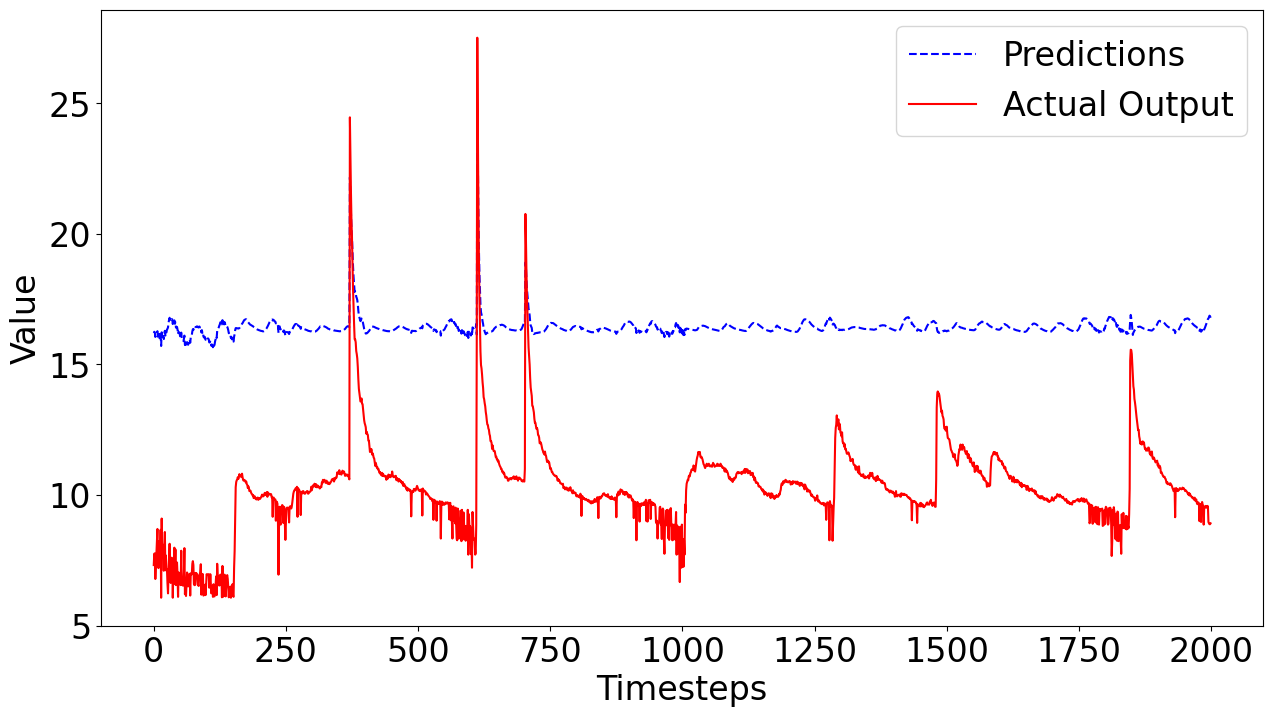

In [ ]:
import matplotlib.pyplot as plt

# Set the font size for both the legend and axis numbers
legend_font_size = 24
axis_font_size = 24

# Create a new figure object with a larger size and a higher DPI for better quality
fig = plt.figure(figsize=(15, 8), dpi=100)

# Create your plot within the new figure object
plt.plot(test_predictions , color = 'blue', label='Predictions', linestyle='--')
plt.plot(test_output, color = 'red', label='Actual Output')

# Add a legend to the plot with a larger font size
plt.legend(fontsize=legend_font_size)

# Increase the font size of the axis numbers
plt.xticks(fontsize=axis_font_size)
plt.yticks(fontsize=axis_font_size)

# Add labels to the axes with a larger font size
plt.xlabel('Timesteps', fontsize=axis_font_size)
plt.ylabel('Value', fontsize=axis_font_size)

# Display the plot
plt.show()

In [ ]:
# retrieve the best hyperparameters
best_params = {'dropout_rate': 0.33699129803466454,
 'learning_rate': 0.0008032352533476955,
 'activation': 'relu',
 'kernel_initializer': None}

# Train the model with the best hyperparameters


# Load the training data
train_data = np.array(df.head(10000))


# Split the training data into input and output sequences
train_input = train_data[:, :]
print('train_input shape', train_input.shape)
train_output = train_data[:, -1:]
print('train_output shape', train_output.shape)

# Define the input and output dimensions
input_dim = df.shape[1]
output_dim = 1

# Define the number of experts
num_experts = 3

# Define the sizes of the hidden layers for each expert
expert_hidden_sizes = [16, 32, 64]

# Define the sizes of the output layers for each expert
expert_output_sizes = [144,144,144]

# Define the sizes of the gating network hidden layers
gating_hidden_sizes = [16, 8]

# Define the size of the output layer of the gating network
gating_output_size = num_experts

# Define the number of training iterations for the EM algorithm
num_iterations = 300

# Define the optimization algorithm
optimizer = SGD(learning_rate=best_params["learning_rate"], momentum=0.9)

# Learning rate scheduler
lr_scheduler = LearningRateScheduler(scheduler)


moe_model, experts, gating_model = build_moe_model_with_autoencoder_cnn_attention(
    input_dim,
    output_dim,
    expert_hidden_sizes,
    expert_output_sizes,
    gating_hidden_sizes,
    num_experts,
    best_params["learning_rate"],
    best_params["activation"],
    best_params["kernel_initializer"],
    best_params["dropout_rate"])

all_trainable_variables = []
for expert in experts:
    all_trainable_variables.extend(expert.trainable_variables)
all_trainable_variables.extend(gating_model.trainable_variables)
optimizer.build(all_trainable_variables)

# create an empty list to store the loss values
losses = []
# Train the MoE model with the EM algorithm
iteration = 0
while iteration < num_iterations:

    # E step: Compute the responsibilities of each expert for each data point
    gating_output = tf.constant(gating_model.predict(train_input), dtype=tf.float64)
    gating_output /= tf.reduce_sum(gating_output, axis=-1, keepdims=True) + 1e-8  # Add a small epsilon value

    # M step: Update the parameters of each expert and the gating network
    for i in range(num_experts):
        expert_input = train_input
        expert_output = experts[i](expert_input)
        expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)

        with tf.GradientTape() as tape:
            # Watch the trainable variables of the expert model
            tape.watch(experts[i].trainable_variables)

            # Define the expert model and calculate the expert_loss
            expert_output = experts[i](expert_input)
            expert_loss = tf.reduce_mean(tf.square(train_output - expert_output), axis=-1)

        # Compute the gradients
        expert_gradient = tape.gradient(expert_loss, experts[i].trainable_variables)
        # Clip gradients for expert models
        expert_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in expert_gradient]

        # Update the variables
        optimizer.apply_gradients(zip(expert_gradient, experts[i].trainable_variables))

    current_learning_rate = scheduler(iteration, optimizer.learning_rate.numpy())
    optimizer.learning_rate.assign(current_learning_rate)

    gating_input = train_input

    with tf.GradientTape() as tape:
        # Watch the trainable variables of the gating model
        tape.watch(gating_model.trainable_variables)

        # Define the gating model and calculate the gating_loss
        gating_output = gating_model(gating_input)
        gating_loss = moe_loss(tf.constant(train_output, dtype=tf.float32), moe_model(train_input), gating_output)


    # Compute the gradients
    gating_gradient = tape.gradient(gating_loss, gating_model.trainable_variables)
    # Clip gradients for the gating model
    gating_gradient = [tf.clip_by_value(grad, -1.0, 1.0) for grad in gating_gradient]

    # Update the variables
    optimizer.apply_gradients(zip(gating_gradient, gating_model.trainable_variables))

    # Evaluate the performance of the MoE model on the training set
    train_loss = moe_loss(train_output, moe_model.predict(train_input), gating_model.predict(train_input))
    moe_model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
    # Make predictions on the test set using the MoE model
    train_predictions = moe_model.predict(train_input)
    moe_mae = mean_absolute_error(train_output, train_predictions)
    moe_mse = mean_squared_error(train_output, train_predictions)
    print(f"MoE model performance: MAE={moe_mae}, MSE={moe_mse}")
    # add the loss to the list
    losses.append(train_loss)
    print('Iteration %d: Training loss = %.6f' % (iteration + 1, train_loss))

    # Stop training if the learning rate becomes too small
    if current_learning_rate < 1e-8:
        print('Learning rate dropped below 1e-6 after iteration %d' % iteration)
        break

    iteration += 1



moe_model.save('moe_models2.h5')
gating_model.save('gating_models2.h5')
for i, expert in enumerate(experts):
    expert.save(f'expert_{i}.h5')


train_input shape (10000, 2)
train_output shape (10000, 1)
313/313 [==============================] - 2s 4ms/step
MoE model performance: MAE=10.12270437681691, MSE=105.69548244057279
Iteration 1: Training loss = 105.695488
313/313 [==============================] - 2s 4ms/step
MoE model performance: MAE=10.112937166671529, MSE=105.4972781954899
Iteration 2: Training loss = 105.497276
313/313 [==============================] - 3s 5ms/step
MoE model performance: MAE=10.079623054932318, MSE=104.82741293595288
Iteration 3: Training loss = 104.827415
313/313 [==============================] - 2s 4ms/step
MoE model performance: MAE=10.003950235710366, MSE=103.31348762703212
Iteration 4: Training loss = 103.313484
313/313 [==============================] - 3s 5ms/step
MoE model performance: MAE=9.904999652739688, MSE=101.3503433488764
Iteration 5: Training loss = 101.350334
313/313 [==============================] - 2s 4ms/step
MoE model performance: MAE=9.80286951239638, MSE=99.3431049811512

**Individual models deployment**

In [ ]:
def create_train_expert_model(i, input_dim, output_dim, X_train, y_train, X_test, y_test, activation, kernel_initializer, dropout_rate):
    # Train each expert model
    if i == 0:  # Autoencoder
        expert_model = Model(inputs=experts[0].input, outputs=experts[0].output)
    elif i == 1:  # CNN
        expert_model = Model(inputs=experts[1].input, outputs=experts[1].output)
    else:  # Attention-based model
        expert_model = Model(inputs=experts[2].input, outputs=experts[2].output)

    expert_model.compile(optimizer=Adam(learning_rate=0.0005), loss='mean_squared_error', metrics=['mae'])
    expert_model.fit(X_train, y_train, batch_size=32, epochs=100, validation_data=(X_test, y_test), verbose=0)

    return expert_model

def objective(trial):
    activation = trial.suggest_categorical('activation', ['relu', 'tanh'])
    kernel_initializer = trial.suggest_categorical('kernel_initializer', ['he_normal', 'lecun_normal'])
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)

    expert_model = create_train_expert_model(i, input_dim, output_dim, train_input, train_output, test_input, test_output, activation, kernel_initializer, dropout_rate)
    loss, mae = expert_model.evaluate(test_input, test_output, verbose=0)

    return mae

study = optuna.create_study(direction='minimize')
for i in range(num_experts):
    study.optimize(objective, n_trials=1)
    best_params = study.best_params
    print(f"Best parameters for expert {i}: {best_params}")

    expert_model = create_train_expert_model(i, input_dim, output_dim, train_input, train_output, test_input, test_output, best_params['activation'], best_params['kernel_initializer'], best_params['dropout_rate'])
    experts[i] = expert_model
# Evaluate the individual expert models
for i, expert_model in enumerate(experts):
    expert_predictions = expert_model.predict(test_input)
    print(expert_predictions[0:10])
    expert_mae = mean_absolute_error(test_output, expert_predictions[:,0].T.reshape(100,1))
    expert_mse = mean_squared_error(test_output, expert_predictions[:,0].T.reshape(100,1))
    print(f"Expert {i} model performance: MAE={expert_mae}, MSE={expert_mse}")

[I 2023-04-26 04:44:24,322] A new study created in memory with name: no-name-3ee9a729-c980-4251-bd9f-acd745459f67
[I 2023-04-26 04:46:34,198] Trial 0 finished with value: 3.5128514766693115 and parameters: {'activation': 'relu', 'kernel_initializer': 'lecun_normal', 'dropout_rate': 0.46523480937255146}. Best is trial 0 with value: 3.5128514766693115.


Best parameters for expert 0: {'activation': 'relu', 'kernel_initializer': 'lecun_normal', 'dropout_rate': 0.46523480937255146}


[I 2023-04-26 04:50:32,340] Trial 1 finished with value: 3.586665391921997 and parameters: {'activation': 'tanh', 'kernel_initializer': 'he_normal', 'dropout_rate': 0.25182505701547925}. Best is trial 0 with value: 3.5128514766693115.


Best parameters for expert 1: {'activation': 'relu', 'kernel_initializer': 'lecun_normal', 'dropout_rate': 0.46523480937255146}


[I 2023-04-26 04:54:46,244] Trial 2 finished with value: 3.527867317199707 and parameters: {'activation': 'relu', 'kernel_initializer': 'lecun_normal', 'dropout_rate': 0.4156644660249619}. Best is trial 0 with value: 3.5128514766693115.


Best parameters for expert 2: {'activation': 'relu', 'kernel_initializer': 'lecun_normal', 'dropout_rate': 0.46523480937255146}
4/4 [==============================] - 0s 3ms/step
[[ 7.2702103]
 [ 8.650709 ]
 [ 7.068842 ]
 [11.79464  ]
 [ 8.716473 ]
 [13.888821 ]
 [ 7.1144557]
 [ 7.2921453]
 [10.830593 ]
 [10.606586 ]]
Expert 0 model performance: MAE=3.5152860225323486, MSE=14.645764550455995
4/4 [==============================] - 0s 3ms/step
[[ 7.242209 ]
 [ 8.495697 ]
 [ 6.993226 ]
 [11.691198 ]
 [ 8.578069 ]
 [13.738373 ]
 [ 7.0779233]
 [ 7.304846 ]
 [10.748892 ]
 [10.517881 ]]
Expert 1 model performance: MAE=3.4292959941510013, MSE=14.036963744267872
4/4 [==============================] - 0s 3ms/step
[[ 7.2372303]
 [ 8.524455 ]
 [ 6.9784255]
 [11.825805 ]
 [ 8.655889 ]
 [13.885411 ]
 [ 7.10109  ]
 [ 7.354578 ]
 [10.89346  ]
 [10.663635 ]]
Expert 2 model performance: MAE=3.5132233203533936, MSE=14.724905662811963
